# Programa Ingenias+ Data Science

## Objetivo del notebook

El objetivo de este notebook es aplicar y comparar técnicas de aprendizaje no supervisado, tanto de clustering como de reducción de dimensionalidad, para identificar patrones y estructuras subyacentes en los datos.

Las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [1]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, pairwise_distances, silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import time
import prince

from utils.codificaciones import *
from utils.funcions import *

In [2]:
# Importar el csv
friesgo_raw = pd.read_csv('datasets/friesgo_analisis.csv')

In [84]:
friesgo_raw.shape

(29224, 43)

## Preprocesado

### Identificación de variables

In [3]:
# Copiar el dataframe
friesgo_cod = friesgo_raw.copy()

In [4]:
# Filas y columnas
friesgo_cod.shape

(29224, 43)

In [5]:
# Columnas presentes
friesgo_cod.columns

Index(['cant_tipos_tabaco', 'es_diabetico', 'cod_provincia',
       'ansiedad_depresion', 'fumado_100_cigarrillos',
       'af_intensa_veces_por_semana', 'tiempo_sentado_min_por_dia',
       'submuestra', 'colesterol_alto', 'ultima_medicion_glucemia',
       'condicion_fumador', 'dolor_malestar_general', 'salud_actual',
       'medido_colesterol', 'cobertura_salud', 'ranking_dieta',
       'capacidad_actividades_cotidianas', 'tamanio_aglomerado',
       'media_fv_diaria', 'nivel_educ', 'edad', 'diagnostico_cosanguineos',
       'tipo_bebida', 'presion_arterial_elevada',
       'af_moderada_veces_por_semana', 'mantiene_ha_alta',
       'nivel_actividad_fisica', 'condicion_actividad',
       'capacidad_cuidado_personal', 'peso_autoreportado_kg', 'freq_cons_alc',
       'imc_autoreportado', 'consumo_sal', 'caminata_veces_por_semana',
       'situacion_conyugal', 'sexo', 'barreras_actividad_fisica',
       'nivel_de_movilidad', 'imc_categorias_autoreportado',
       'altura_autoreportado_c

### Evaluación y procesamiento de nulos

In [6]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
cant_tipos_tabaco,0,0.0%
es_diabetico,0,0.0%
cod_provincia,0,0.0%
ansiedad_depresion,0,0.0%
fumado_100_cigarrillos,0,0.0%
af_intensa_veces_por_semana,0,0.0%
tiempo_sentado_min_por_dia,1110,3.8%
submuestra,0,0.0%
colesterol_alto,0,0.0%
ultima_medicion_glucemia,0,0.0%


In [7]:
# Remover columnas con > 50% de nulos
friesgo_cod.drop(columns=['tipo_bebida', 'tratamiento_medico_col'], inplace=True)

In [8]:
friesgo_cod.shape

(29224, 41)

In [9]:
variables_num = {
    'tiempo_sentado_min_por_dia', 'media_fv_diaria','edad', 'peso_autoreportado_kg','altura_autoreportado_cm','imc_autoreportado'
}

In [10]:
variables_cat = {
    'es_diabetico', 'cod_provincia',
       'ansiedad_depresion', 'fumado_100_cigarrillos', 'submuestra', 'colesterol_alto', 'ultima_medicion_glucemia',
       'condicion_fumador', 'dolor_malestar_general', 'salud_actual',
       'medido_colesterol', 'cobertura_salud', 'ranking_dieta',
       'capacidad_actividades_cotidianas', 'tamanio_aglomerado','nivel_educ','diagnostico_cosanguineos', 'presion_arterial_elevada',
       'af_moderada_veces_por_semana', 'mantiene_ha_alta',
       'nivel_actividad_fisica', 'condicion_actividad',
       'capacidad_cuidado_personal', 'freq_cons_alc', 'consumo_sal', 'caminata_veces_por_semana',
       'situacion_conyugal', 'sexo', 'barreras_actividad_fisica',
       'nivel_de_movilidad', 'imc_categorias_autoreportado', 'periodicidad_fumador', 'imc_categoria','cant_tipos_tabaco','af_intensa_veces_por_semana'
}

In [11]:
# Eliminar los nulos para no afectar el permutations importance
friesgo_cod = friesgo_cod.dropna()
friesgo_cod.shape

(12955, 41)

### Codificación de columnas

In [12]:
# Codificación de columnas categoricas
le = LabelEncoder()
for columnas in variables_cat:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [13]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(12955, 41)

### Estandarizacion

In [14]:
# Defino columna objetivo y features (para evitar estandarizar los valores de las etiquetas)
col_obj = friesgo_cod['mantiene_ha_alta']
features = friesgo_cod.drop(columns=['mantiene_ha_alta'])

In [15]:
features.shape

(12955, 40)

In [16]:
# Estandarización de los datos 
scaler = StandardScaler()
features_stn = scaler.fit_transform(features)
features_stn = pd.DataFrame(features_stn, columns=features.columns) # colocar nuevamente los nombres de las columnas para ubicar la columna objetivo en permutations importance
features_stn.index = col_obj.index # coloco los indices anteriores para luego poder operar sobre ellos
features_stn.shape

(12955, 40)

#### Eliminacion de outliers

In [17]:
# Creo un dataframe solo de variables numericaspara facilitar el graficado de outliers
friesgo_num = features_stn.filter(items=variables_num)

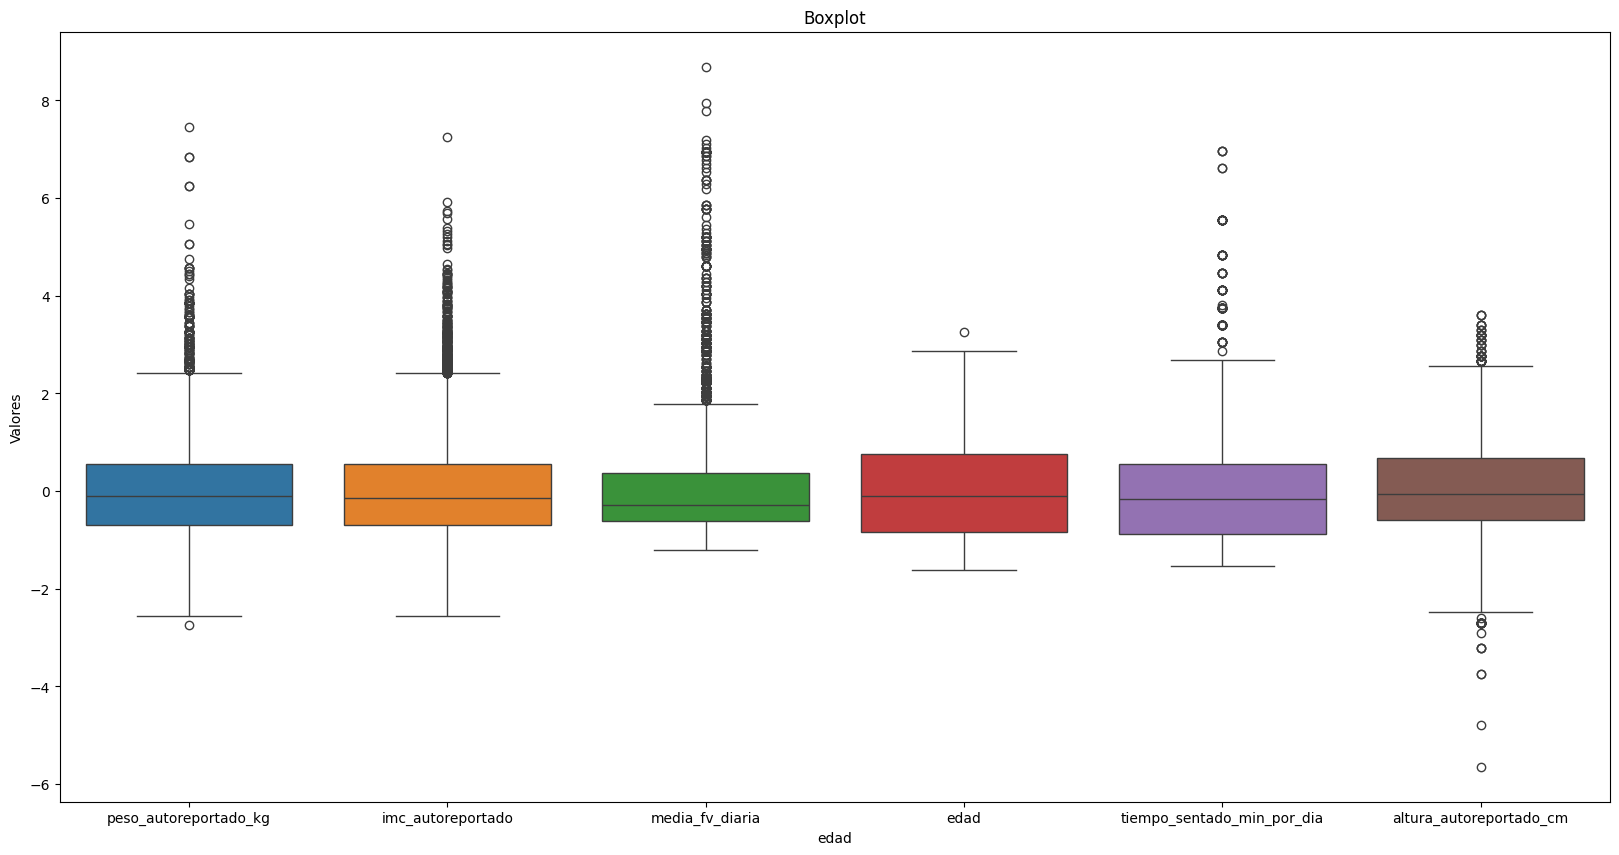

In [18]:
# analisis de los valores para deteccion de outliers en las columnas numericas a utlizar
plt.figure(figsize=(20, 10))
sns.boxplot(data=friesgo_num)
plt.title('Boxplot')
plt.xlabel('edad')
plt.ylabel('Valores')
plt.show()

In [19]:
# Calculamos la cantidad y porcentaje de ouliers
columnas_c_outliers = friesgo_num.columns
indices_outliers = identificar_outliers(features_stn,columnas_c_outliers)

In [20]:
print(f'El porcentaje de outliers es de {(len(indices_outliers)/len(features_stn))*100} %')
print(f'El total numerico de outliers es de : {len(indices_outliers)}')

El porcentaje de outliers es de 8.714781937475879 %
El total numerico de outliers es de : 1129


El porcentaje de outliers es relativamente bajo para cada columna y en total de 1129 registros como maximo con estos, por lo que seran eliminados a continuacion. Se eliminaran el mayor porcentaje posible, aunque el dataframe de salida de este preprocesado sera utilizado para realizar un permutations importance con un modelo de random forest, al cual no afectan  en sobremedida por los outliers, como si es el caso con los algoritmos de clustering, por lo que si las columnas resultantes de permutations importance tienen outliers seran eliminados al 100%.

In [21]:
# eliminar los outliers
col_obj = col_obj.drop(index=indices_outliers)
features_stn = features_stn.drop(indices_outliers,axis=0)

In [22]:
features_stn.shape

(11826, 40)

In [23]:
# verificar que los indices coincidan
iguales = col_obj.index == features_stn.index
np.unique(iguales)

array([ True])

Los registros iniciales fueron 12955 y al eliminar los outliers 11826, una diferencia de 1129 igual a la cantidad de outliers, por lo que se eliminaron el 100% en teoria, ahora observaremos los graficos.

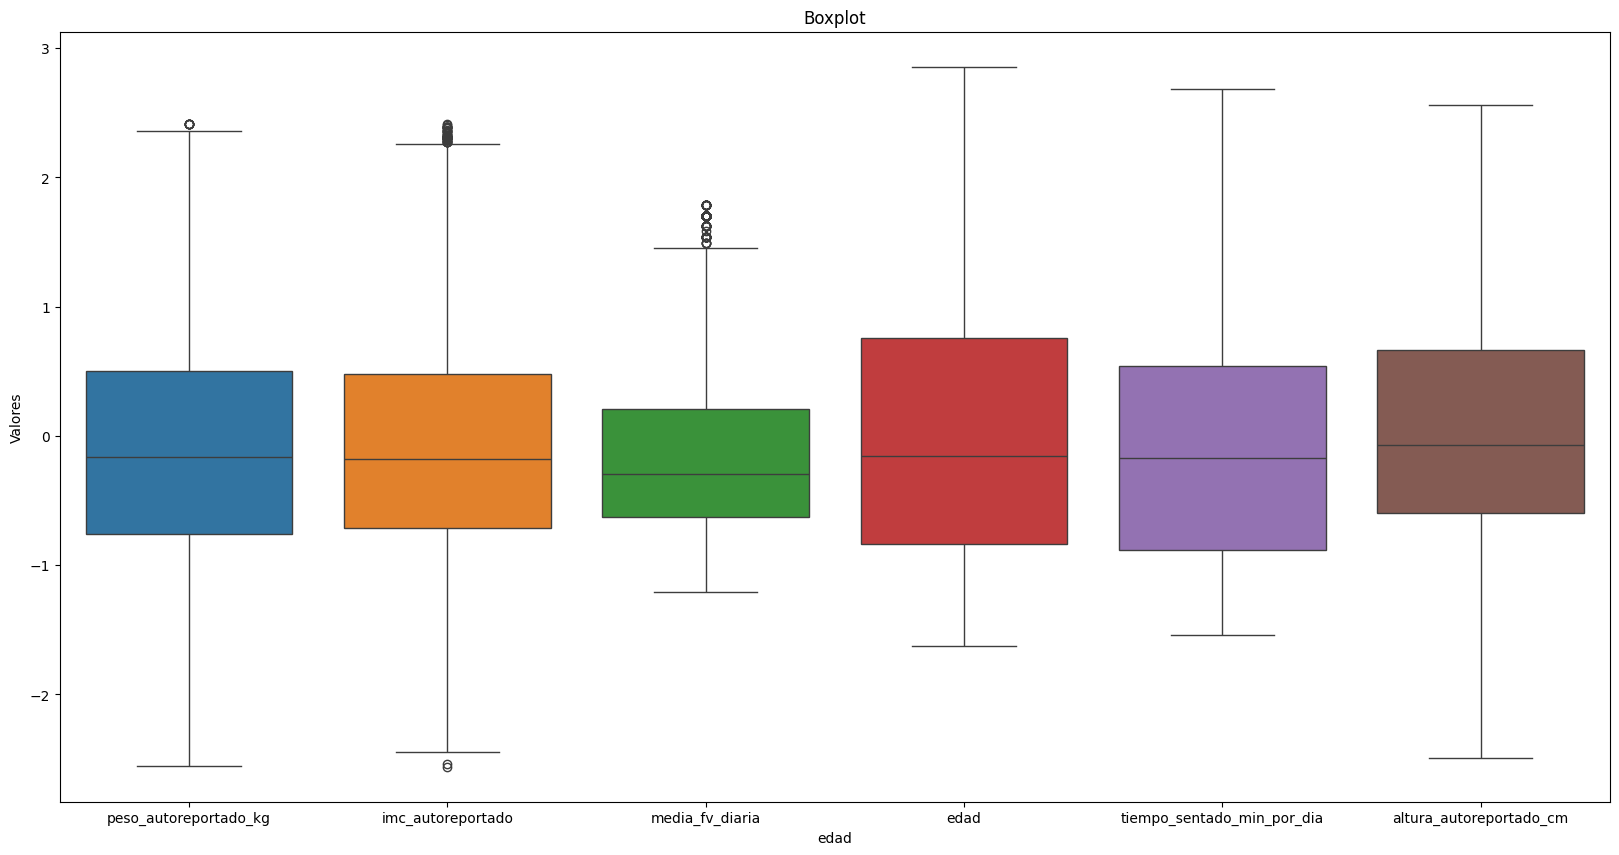

In [24]:
# Graficar
friesgo_num2 = features_stn.filter(items=variables_num)
# analisis de los valores para deteccion de outliers en las columnas numericas a utlizar
plt.figure(figsize=(20, 10))
sns.boxplot(data=friesgo_num2)
plt.title('Boxplot')
plt.xlabel('edad')
plt.ylabel('Valores')
plt.show()

In [25]:
# Calcular el porcentaje y numero de ouliers 
print(calcular_porcentaje_outliers(friesgo_num2.imc_autoreportado))
print(calcular_porcentaje_outliers(friesgo_num2.media_fv_diaria))
print(calcular_porcentaje_outliers(friesgo_num2.peso_autoreportado_kg))
print(calcular_porcentaje_outliers(friesgo_num2.tiempo_sentado_min_por_dia))
print(calcular_porcentaje_outliers(friesgo_num2.edad))
print(calcular_porcentaje_outliers(friesgo_num2.altura_autoreportado_cm))

(0.43125317097919835, 51)
(2.545239303230171, 301)
(0.06764755623203111, 8)
(0.0, 0)
(0.0, 0)
(0.0, 0)


Se eliminaron la mayoria de los outliers quedando solo alrededor de 400 (esto es un problema con la funcion de medicion de porcentaje / de identificacion de outliers que no pudimos solucionar a tiempo)

## Reducción de dimensionalidad

### Paso 1 : Permutation Importance

Se aplica un algoritmo de clasificación Random Forest para evaluar la importancia de las características del dataset. Esto nos permite identificar las columnas más relevantes, lo que facilita la reducción de dimensionalidad al eliminar aquellas con menor relevancia.

In [108]:
# Separar los conjuntos para entrenamiento y testeo
y = col_obj
X = features_stn
X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(X, y, test_size=0.3, random_state=42)

In [109]:
# Entrenar el modelo para tener los parametros de accuracy de base
modelo = RandomForestClassifier(random_state=42,criterion= 'gini', n_estimators=200, max_depth=8)

# Ajustar el modelo
modelo.fit(X_train_pi, y_train_pi)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [110]:
# Calcular el acurracy base
y_pred_pi = modelo.predict(X_test_pi)
acc = accuracy_score(y_test_pi, y_pred_pi)
acc

0.7302705749718151

In [111]:
# Calcular Permutation Importance
perm = permutation_importance(modelo, X_test_pi, y_test_pi,random_state=1)

In [112]:
# Ordenar las características por importancia promedio
indices = np.argsort(perm.importances_mean)  # Orden ascendente
features = X_test_pi.columns[indices]
importances = perm.importances_mean[indices]
importances_std = perm.importances_std[indices]

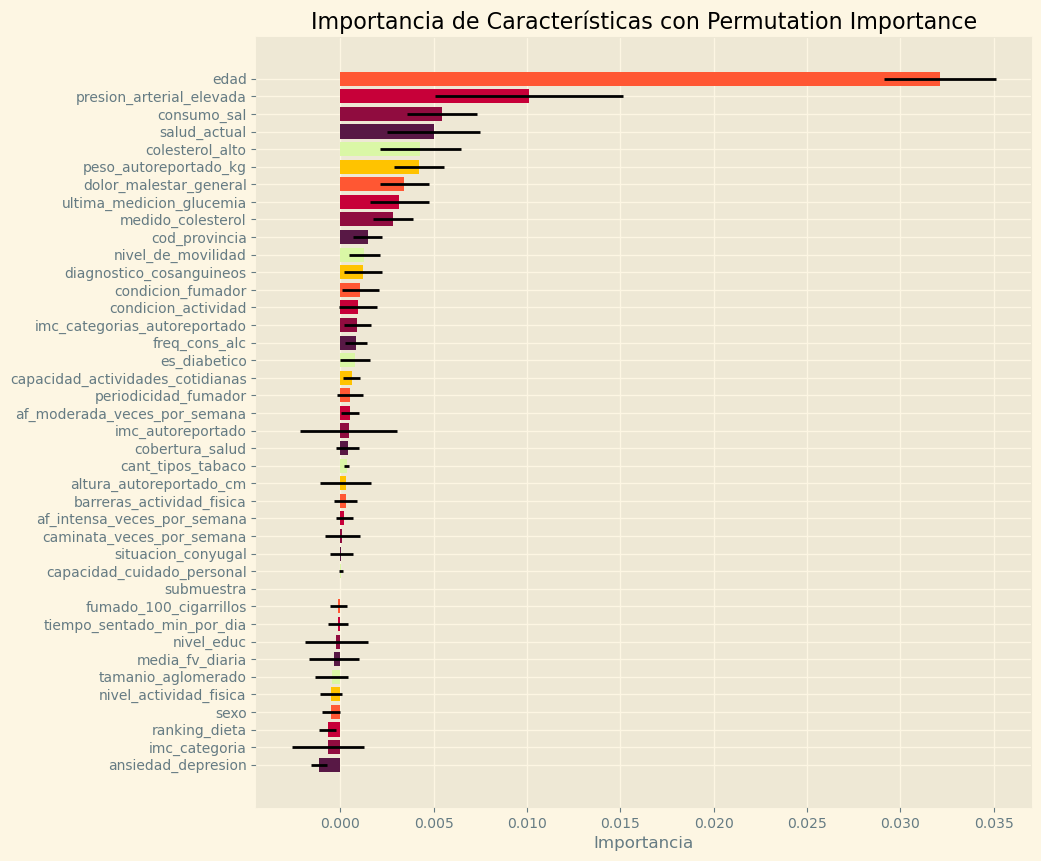

In [113]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 10))
plt.barh(features, importances, xerr=importances_std, align='center',color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.xlabel('Importancia')
plt.title('Importancia de Características con Permutation Importance')
plt.show()

Se seleccionarán las 10 características principales, que son aquellas que más contribuyen a la precisión del modelo. 

In [26]:
# Se seleccionaran a partir del dataframe sin procesar para rescatar los valores eliminados por ser nulos en columnas que ya no estan presentes
friesgo_reducida = friesgo_raw.filter(items=['edad','presion_arterial_elevada','consumo_sal','salud_actual','colesterol_alto','peso_autoreportado_kg','dolor_malestar_general','ultima_medicion_glucemia','medido_colesterol','cod_provincia'
])

In [115]:
calcular_nulos_y_porcentaje(friesgo_reducida)

,Nulos,Porcentaje
edad,0,0.0%
presion_arterial_elevada,12997,44.47%
consumo_sal,0,0.0%
salud_actual,0,0.0%
colesterol_alto,0,0.0%
peso_autoreportado_kg,1011,3.46%
dolor_malestar_general,0,0.0%
ultima_medicion_glucemia,0,0.0%
medido_colesterol,0,0.0%
cod_provincia,0,0.0%


Este nuevo DataFrame servirá de entrada para los siguientes algoritmos no supervisados.

### Preprocesado de df reducido

In [27]:
auxm = friesgo_reducida.copy().dropna()
auxm.shape

(15599, 10)

In [28]:
auxm.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,32,1.0,5,3,2,104.0,1,2,1,2
7,42,2.0,3,2,1,57.0,1,1,1,2
8,32,1.0,4,1,2,82.0,1,3,1,2
11,76,1.0,5,3,2,92.0,1,1,1,2
13,63,1.0,4,4,2,84.0,2,1,1,2


In [29]:
print(calcular_porcentaje_outliers(auxm.edad))
print(calcular_porcentaje_outliers(auxm.peso_autoreportado_kg))

(0.006410667350471184, 1)
(1.6988268478748638, 265)


In [30]:
auxm.dtypes

edad                          int64
presion_arterial_elevada    float64
consumo_sal                   int64
salud_actual                  int64
colesterol_alto               int64
peso_autoreportado_kg       float64
dolor_malestar_general        int64
ultima_medicion_glucemia      int64
medido_colesterol             int64
cod_provincia                 int64
dtype: object

In [31]:
auxm.columns

Index(['edad', 'presion_arterial_elevada', 'consumo_sal', 'salud_actual',
       'colesterol_alto', 'peso_autoreportado_kg', 'dolor_malestar_general',
       'ultima_medicion_glucemia', 'medido_colesterol', 'cod_provincia'],
      dtype='object')

In [32]:
# Codificación de columnas categoricas
le = LabelEncoder()
categoricas = ['presion_arterial_elevada', 'consumo_sal', 'salud_actual','colesterol_alto', 'dolor_malestar_general','ultima_medicion_glucemia', 'medido_colesterol', 'cod_provincia']
for columnas in categoricas:
    auxm[columnas] = le.fit_transform(auxm[columnas])

In [33]:
auxm.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,32,0,3,2,1,104.0,0,1,0,0
7,42,1,1,1,0,57.0,0,0,0,0
8,32,0,2,0,1,82.0,0,2,0,0
11,76,0,3,2,1,92.0,0,0,0,0
13,63,0,2,3,1,84.0,1,0,0,0


In [34]:
# Estandarizar columnas numericas
numericas = ['edad','peso_autoreportado_kg']
auxm['edad'] = scaler.fit_transform(auxm[['edad']]).flatten()
auxm['peso_autoreportado_kg'] = scaler.fit_transform(auxm[['peso_autoreportado_kg']]).flatten()

In [35]:
auxm.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,-0.790248,0,3,2,1,1.712710,0,1,0,0
7,-0.230687,1,1,1,0,-1.103666,0,0,0,0
8,-0.790248,0,2,0,1,0.394406,0,2,0,0
11,1.671823,0,3,2,1,0.993636,0,0,0,0
13,0.944392,0,2,3,1,0.514252,1,0,0,0


## Paso 2: Modelos de reducción de dimensionalidad

### PCA

#### Estandarizar datos

PCA es sensible a la escala de las columnas. La estandarización asegura que cada característica contribuya igualmente al análisis.

In [142]:
# Estandarización de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(auxm)
scaled_data

array([[-0.79024847, -1.22795676,  1.39266459, ..., -0.08137297,
        -0.66339768, -1.3281036 ],
       [-0.23068688,  0.81436092, -0.93988224, ..., -0.84191036,
        -0.66339768, -1.3281036 ],
       [-0.79024847, -1.22795676,  0.22639117, ...,  0.67916443,
        -0.66339768, -1.3281036 ],
       ...,
       [ 0.8884363 ,  0.81436092,  0.22639117, ..., -0.08137297,
        -0.66339768,  1.89427434],
       [ 1.55991021, -1.22795676,  0.22639117, ..., -0.84191036,
        -0.66339768,  1.89427434],
       [-0.3425992 , -1.22795676,  1.39266459, ..., -0.84191036,
        -0.66339768,  1.89427434]])

#### Evaluar el número óptimo de componentes para PCA

Para conservar el 80% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [143]:
pca = PCA(n_components = 0.80)
pca_data = pca.fit_transform(scaled_data)
n_components = pca.n_components_

# Ver el número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {n_components}")

Número de componentes seleccionados: 7


#### Aplicar PCA 

Se aplica PCA con el número de componentes principales calculado con anterioridad.

In [144]:
# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components = n_components)
pca_opt_data = pca_opt.fit_transform(scaled_data)

# Convertir a DataFrame para facilitar el manejo
pca_df = pd.DataFrame(data = pca_opt_data, columns = [f'PC{i+1}' for i in range(n_components)])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.629346,0.185646,2.288828,-0.396797,-0.451186,1.071706,1.103503
1,-0.178164,-2.344534,-0.824865,-1.115680,0.981511,0.797168,-0.809020
2,0.745412,-0.926844,2.125307,-0.883871,-0.097137,0.102606,-0.089116
3,-1.939684,-0.239334,1.963438,-0.890369,-1.172631,-0.068190,0.465731
4,-2.097166,0.971080,0.342604,-1.565634,-0.278024,-0.496128,0.785299
...,...,...,...,...,...,...,...
15594,-1.392193,-0.135373,-1.038395,1.444509,-0.572221,-1.381308,-0.073645
15595,0.777949,-0.689554,0.153848,2.245567,0.412521,-0.240742,0.795670
15596,-1.212397,-0.368224,-0.397063,2.199480,0.755793,0.816464,-0.699200
15597,-2.161850,-0.431731,0.122281,1.698657,0.180230,-0.619133,-1.949142


#### Visualizar la varianza explicada 

Permite ver cómo cada componente principal contribuye a la varianza total y cómo se acumula la varianza explicada.

In [145]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada')
for i in range(n_components):
    print('PC{}: {}'.format(i+1, pca.explained_variance_ratio_[i]))

Varianza explicada
PC1: 0.2417626027904551
PC2: 0.13237475735731197
PC3: 0.11393683287049838
PC4: 0.10216067470183089
PC5: 0.09632744060140556
PC6: 0.07877567987501867
PC7: 0.07476928609307708


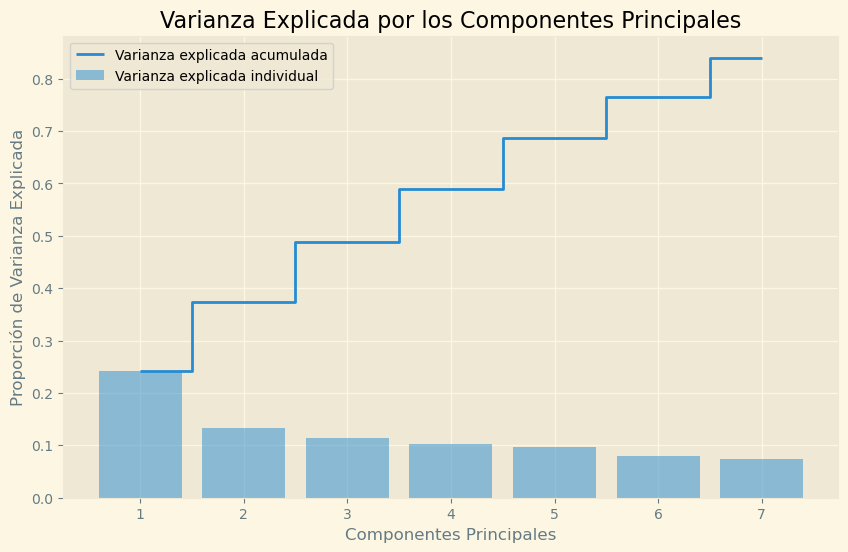

In [146]:
# Visualización de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(np.cumsum(explained_variance)) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.show()

In [147]:
def plot_3d_scatter(ax, data, view_angle=(90, 30)):
    """
    Función para crear un scatterplot 3D dado un subplot y datos.
    
    Parameters:
    - ax: El objeto Axes3D donde se dibujará el scatterplot.
    - data: DataFrame que contiene las columnas 'PC1', 'PC2', 'PC3', y 'PC4'.
    - view_angle: Tuple que contiene los ángulos de elevación y azimut (elev, azim).
    """
    '''
    group1 = data[data['PC4'] == 0]
    group2 = data[data['PC4'] == 1]
    group3 = data[data['PC4'] == 2]
    
    # Graficar los tres grupos con diferentes colores y marcadores
   
    ax.scatter(group1['PC1'], group1['PC2'], group1['PC3'], color='r', label='Cluster 0', marker='o', alpha=0.7)
    ax.scatter(group2['PC1'], group2['PC2'], group2['PC3'], color='g', label='Cluster 1', marker='^', alpha=0.7)
    ax.scatter(group3['PC1'], group3['PC2'], group3['PC3'], color='b', label='Cluster 2', marker='s', alpha=0.7)
'''
    ax.scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['PC4'],
                     cmap='tab20', marker='o', alpha=0.7)
    
    # Etiquetas de los ejes
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # Configurar la vista
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Título del gráfico con el ángulo actual
    ax.set_title(f'Vista: Elev={view_angle[0]}, Azim={view_angle[1]}')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


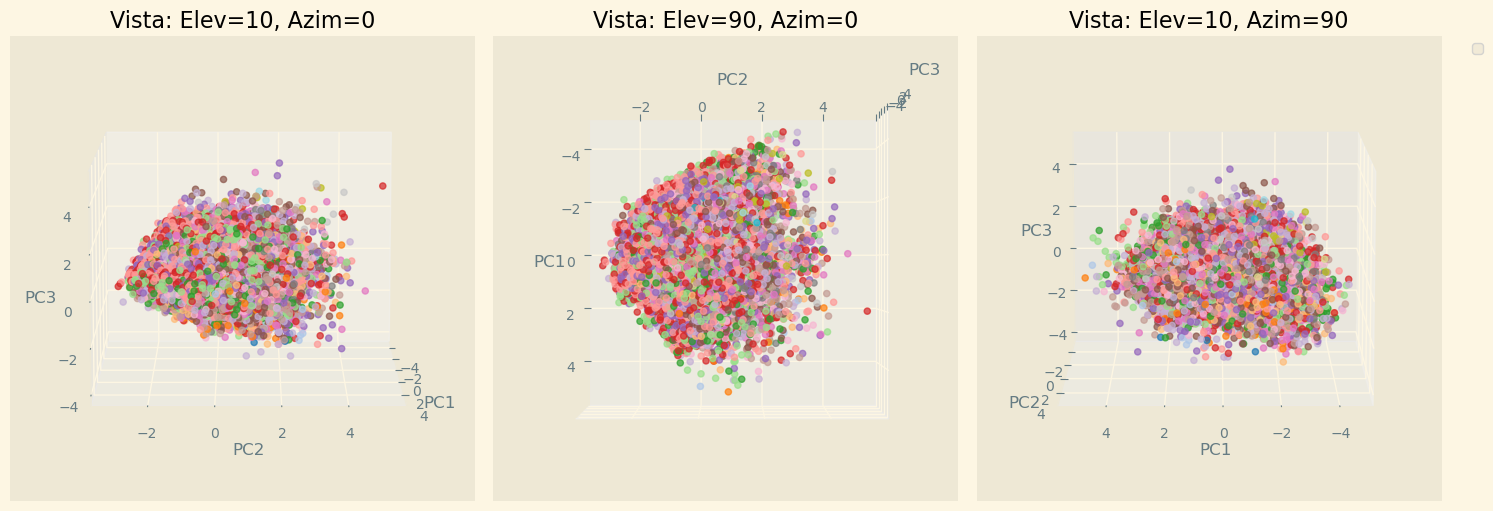

In [148]:
# Configurar la figura con tres subplots
fig = plt.figure(figsize=(15, 5))

# Definir los ángulos para cada vista
angles = [(10, 0), (90, 0), (10, 90)]

# Crear subplots con diferentes vistas usando la función
for i, angle in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_3d_scatter(ax, pca_df, view_angle=angle)

# Añadir una leyenda fuera de los subplots
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## FAMD

In [349]:
subset_famd = friesgo_reducida.copy().dropna()

In [350]:
subset_famd.dtypes

edad                          int64
presion_arterial_elevada    float64
consumo_sal                   int64
salud_actual                  int64
colesterol_alto               int64
peso_autoreportado_kg       float64
dolor_malestar_general        int64
ultima_medicion_glucemia      int64
medido_colesterol             int64
cod_provincia                 int64
dtype: object

In [351]:

le = LabelEncoder()
categoricas = ['presion_arterial_elevada', 'consumo_sal', 'salud_actual','colesterol_alto', 'dolor_malestar_general','ultima_medicion_glucemia', 'medido_colesterol', 'cod_provincia']
for columnas in categoricas:
    auxm[columnas] = le.fit_transform(auxm[columnas])

In [352]:
subset_famd[categoricas] = subset_famd[categoricas].astype('category')


In [353]:
subset_famd.dtypes

edad                           int64
presion_arterial_elevada    category
consumo_sal                 category
salud_actual                category
colesterol_alto             category
peso_autoreportado_kg        float64
dolor_malestar_general      category
ultima_medicion_glucemia    category
medido_colesterol           category
cod_provincia               category
dtype: object

In [354]:
subset_famd['peso_autoreportado_kg'] = subset_famd['peso_autoreportado_kg'].astype('float')
subset_famd['edad']=subset_famd['edad'].astype('float')


In [355]:
subset_famd.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,32.0,1.0,5,3,2,104.0,1,2,1,2
7,42.0,2.0,3,2,1,57.0,1,1,1,2
8,32.0,1.0,4,1,2,82.0,1,3,1,2
11,76.0,1.0,5,3,2,92.0,1,1,1,2
13,63.0,1.0,4,4,2,84.0,2,1,1,2


In [356]:
subset_famd['edad'] = scaler.fit_transform(subset_famd[['edad']]).flatten()
subset_famd['peso_autoreportado_kg'] = scaler.fit_transform(subset_famd[['peso_autoreportado_kg']]).flatten()

In [357]:
subset_famd.dtypes

edad                         float64
presion_arterial_elevada    category
consumo_sal                 category
salud_actual                category
colesterol_alto             category
peso_autoreportado_kg        float64
dolor_malestar_general      category
ultima_medicion_glucemia    category
medido_colesterol           category
cod_provincia               category
dtype: object

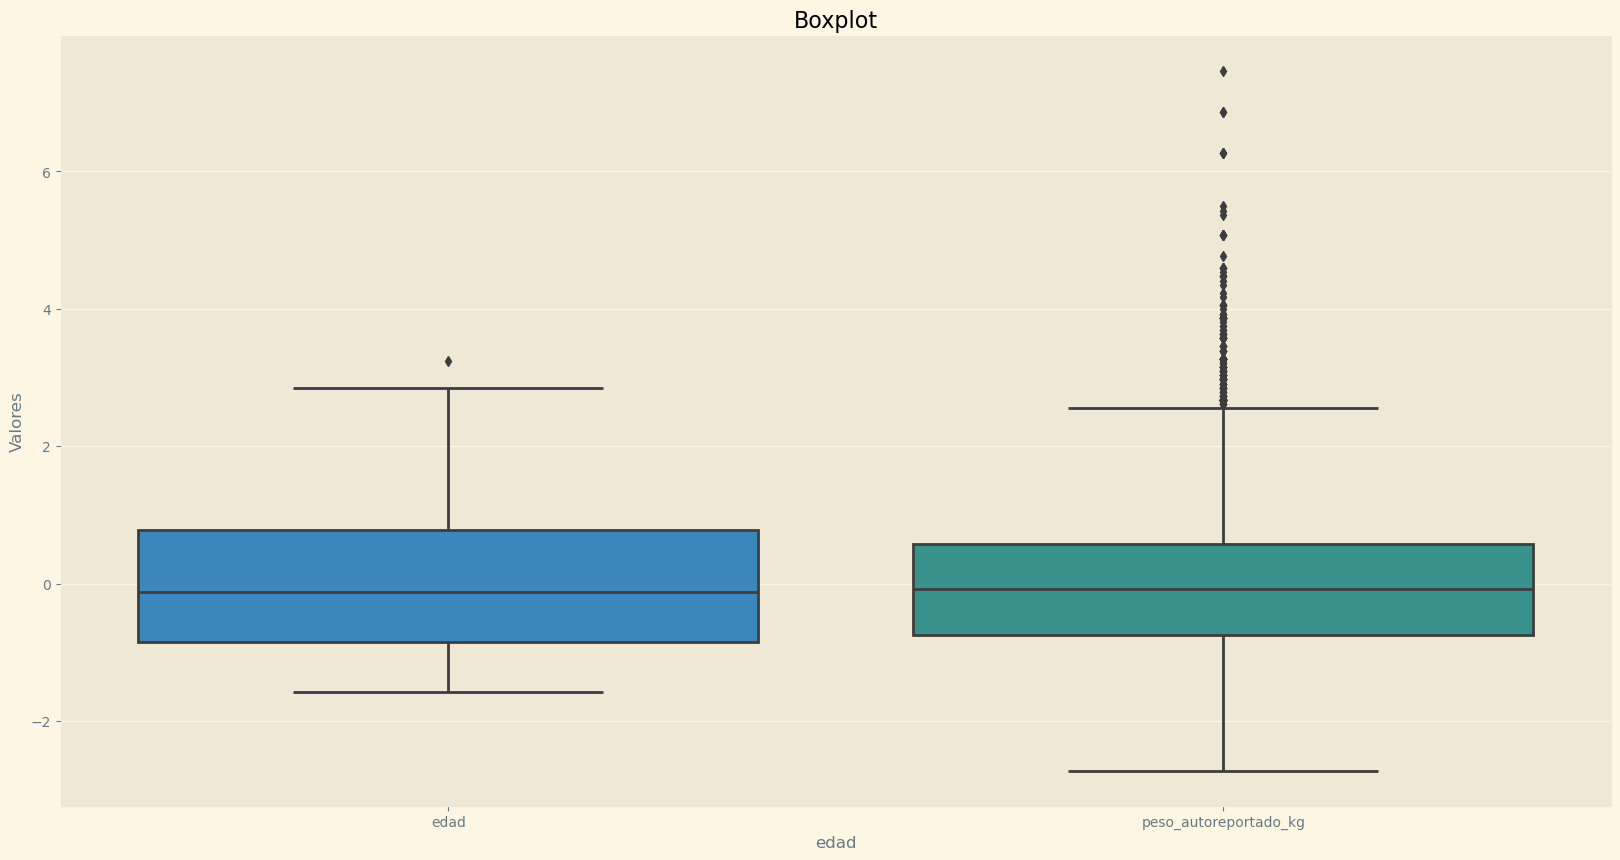

In [358]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=subset_famd[numericas])
plt.title('Boxplot')
plt.xlabel('edad')
plt.ylabel('Valores')
plt.show()

In [359]:
subset_famd = subset_famd[subset_famd['peso_autoreportado_kg'] <= 120]


In [360]:
calcular_nulos_y_porcentaje(subset_famd)

,Nulos,Porcentaje
edad,0,0.0%
presion_arterial_elevada,0,0.0%
consumo_sal,0,0.0%
salud_actual,0,0.0%
colesterol_alto,0,0.0%
peso_autoreportado_kg,0,0.0%
dolor_malestar_general,0,0.0%
ultima_medicion_glucemia,0,0.0%
medido_colesterol,0,0.0%
cod_provincia,0,0.0%


In [362]:
famd = prince.FAMD(n_components=7, engine='sklearn')
famd.fit(subset_famd)

c:\Users\Lenovo\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.40605709482056684, -0.7955256632180482, -0.3710810352040657, -0.5225843751300573, -0.40763279765520966, -0.38063247643973935, -0.3779281261939868, -0.4687831873842664, -0.3809691704254658, -0.40161223902896065, -0.29829526114998883, -0.31785549773981553, -0.36127716127039267, -0.42668835553994394, -0.2970030012348082, -0.4503704197312566, -0.41511292244480347, -0.3113346918336026, -0.34157597365531367, -0.2842083894186393, -0.5166625479688073, -0.30760599814203016, -0.37758872053396825, -0.2166242945873086, -0.9492541297156571, -1.7434683911385995, -0.2433815241926834, -0.6326784881465631, -0.8562265577520266, -1.4523656512734795, -0.8701885010948239, -1.709605644125809, -0.9699636799154652, -0.36934942969771434, -1.6535651902247366, -1.102363870487108, -0.2247577778892489, -1.2629228150592697, -1.55081461277703, -0.6160450528556285, -0.98204928

FAMD(n_components=7)

In [363]:
eigenvalues = famd.eigenvalues_
print(eigenvalues)


[8.63918103 5.65568168 5.48537985 4.58071905 4.38167873 4.31247657
 4.14984578]


In [364]:
total_variance = eigenvalues.sum()
total_variance

37.2049626877021

In [365]:
explained_variance_ratio = eigenvalues / total_variance
print(explained_variance_ratio)

[0.23220507 0.15201417 0.14743678 0.12312118 0.11777135 0.11591133
 0.11154011]


In [366]:
total_variance_explained = explained_variance_ratio.sum()
print(total_variance_explained)

1.0


In [367]:
famd2 = prince.FAMD(n_components=3, engine='sklearn')
famd2.fit(subset_famd)

c:\Users\Lenovo\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.40605709482056684, -0.7955256632180482, -0.3710810352040657, -0.5225843751300573, -0.40763279765520966, -0.38063247643973935, -0.3779281261939868, -0.4687831873842664, -0.3809691704254658, -0.40161223902896065, -0.29829526114998883, -0.31785549773981553, -0.36127716127039267, -0.42668835553994394, -0.2970030012348082, -0.4503704197312566, -0.41511292244480347, -0.3113346918336026, -0.34157597365531367, -0.2842083894186393, -0.5166625479688073, -0.30760599814203016, -0.37758872053396825, -0.2166242945873086, -0.9492541297156571, -1.7434683911385995, -0.2433815241926834, -0.6326784881465631, -0.8562265577520266, -1.4523656512734795, -0.8701885010948239, -1.709605644125809, -0.9699636799154652, -0.36934942969771434, -1.6535651902247366, -1.102363870487108, -0.2247577778892489, -1.2629228150592697, -1.55081461277703, -0.6160450528556285, -0.98204928

FAMD(n_components=3)

In [368]:
eigenvalues2 = famd2.eigenvalues_
total_variance2 = eigenvalues2.sum()
explained_variance_ratio2 = eigenvalues2 / total_variance2
total_variance_explained2 = explained_variance_ratio2.sum()
print(explained_variance_ratio2)
print(total_variance_explained2)

[0.4405492  0.28330583 0.27614497]
1.0


In [369]:
row_coord_FAMD = famd2.row_coordinates(subset_famd)

c:\Users\Lenovo\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.40605709482056684, -0.7955256632180482, -0.3710810352040657, -0.5225843751300573, -0.40763279765520966, -0.38063247643973935, -0.3779281261939868, -0.4687831873842664, -0.3809691704254658, -0.40161223902896065, -0.29829526114998883, -0.31785549773981553, -0.36127716127039267, -0.42668835553994394, -0.2970030012348082, -0.4503704197312566, -0.41511292244480347, -0.3113346918336026, -0.34157597365531367, -0.2842083894186393, -0.5166625479688073, -0.30760599814203016, -0.37758872053396825, -0.2166242945873086, -0.9492541297156571, -1.7434683911385995, -0.2433815241926834, -0.6326784881465631, -0.8562265577520266, -1.4523656512734795, -0.8701885010948239, -1.709605644125809, -0.9699636799154652, -0.36934942969771434, -1.6535651902247366, -1.102363870487108, -0.2247577778892489, -1.2629228150592697, -1.55081461277703, -0.6160450528556285, -0.98204928

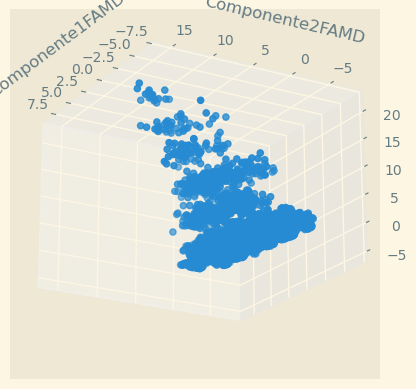

In [370]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(row_coord_FAMD.iloc[:, 0], row_coord_FAMD.iloc[:, 1], row_coord_FAMD.iloc[:, 2])

ax.set_xlabel('Componente1FAMD')
ax.set_ylabel('Componente2FAMD')
ax.set_zlabel('Componente3FAMD')
ax.view_init(elev=-20, azim=150)

plt.show()

### ACA ESTAN LAS COORDENADAS DE LAS 15599 FILAS EN LAS COMPONENTES QUE DIO EL FAMD --- LOS INDEX ESTÁN SALTEADO PORQUE SE ELIMINARON FILAS AL ELIMINAR NULOS Y OUTLIERS

In [372]:

# Create a new DataFrame with components as columns and row coordinates as rows
component_df = pd.DataFrame(row_coord_FAMD.values, columns=[f"Component {i+1}" for i in range(row_coord_FAMD.shape[1])], index=subset_famd.index)

print(component_df)

       Component 1  Component 2  Component 3
0         1.748821     3.027939    -2.895087
7         1.910887     4.208470    -4.114388
8        -0.241075     3.143220    -3.443354
11        2.867338     2.091988    -2.176156
13        4.132285    -0.726443    -0.842425
...            ...          ...          ...
29216     2.379518     0.273234    -0.644691
29217    -0.167768     3.597674    -2.837486
29220     2.363352     2.167943    -2.444995
29221     4.018678     0.662047    -1.173047
29223     3.661014     0.082961     0.772197

[15599 rows x 3 columns]


## Análisis de modelos

### Modelo 1: K-Means

Para la aplicacion de este modelo se seguiran los siguientes pasos:

+ 1 : Calculo de la cantidad optima de clusters mediante la tecnica visual del "codo"
+ 2 : Calculo de la cantidad optima de cluster mediante metodo Silhouette Score
+ 3 : Aplicacion del modelo y graficado de clusters



#### Paso 1

In [36]:
# Test codo pca_df reducida
inertias = []
k_range = range(1,15) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=500, random_state=42)
    kmeans.fit(auxm) # aplicar kmeans a mi dataframe
    inertias.append(kmeans.inertia_)

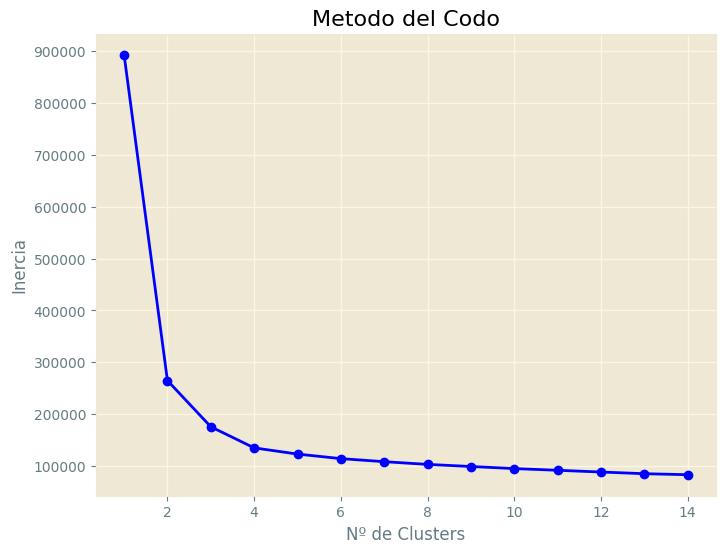

In [37]:
# Graficar el metodo del codo
plt.figure(figsize=(8, 6))
plt.style.use('Solarize_Light2')
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Nº de Clusters')
plt.ylabel('Inercia')
plt.title('Metodo del Codo')
plt.show()

Del grafico puede observarse que la inercia comienza a disminuir de manera menos pronunciada alrededor de los 2 a 4 clusters, aunque el codo es pronunciado, se utilizaran esos valores de cluster (2,3,4) y se evaluaran con Silhouette Score para determinar el optimo.

#### Paso 2

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 2, el Silhouette Score promedio es: 0.56


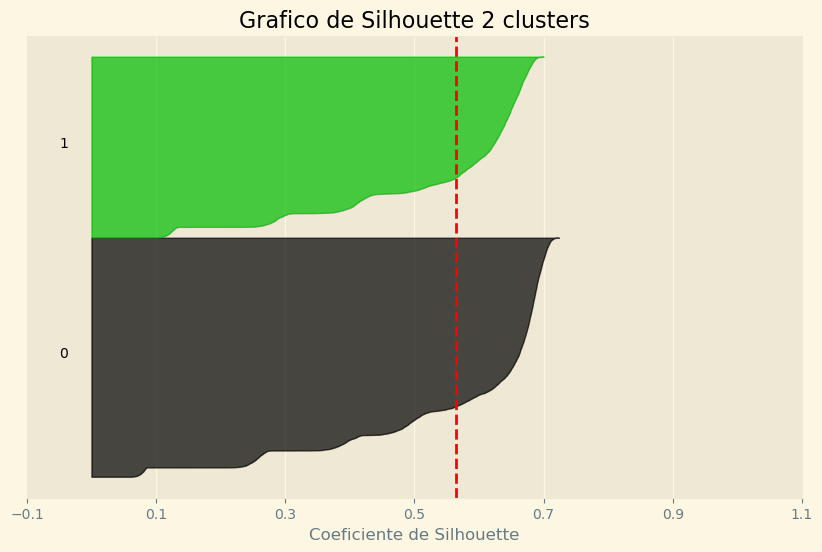

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 3, el Silhouette Score promedio es: 0.43


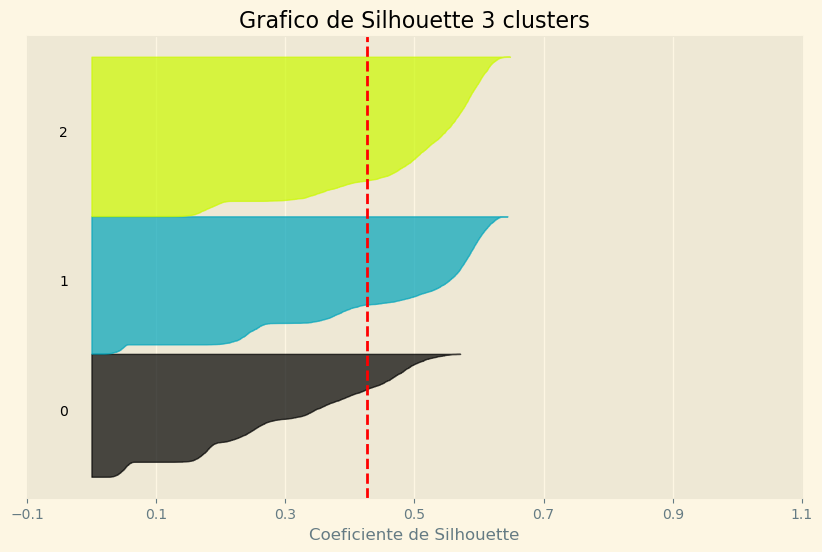

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 4, el Silhouette Score promedio es: 0.36


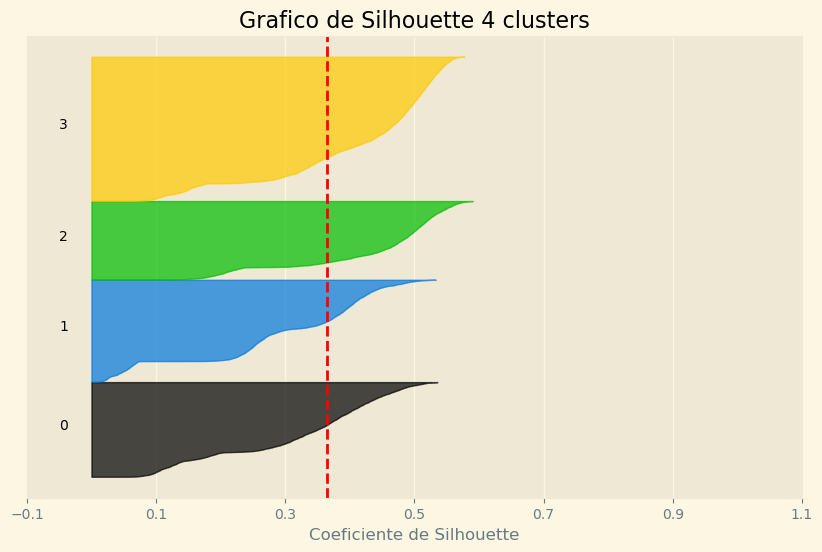

In [258]:
range_n_clusters = [2,3,4]  # Numeros de clusters a probar

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(auxm)
    
    # Calcular el Silhouette Score promedio
    silhouette_avg = silhouette_score(auxm, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, el Silhouette Score promedio es: {silhouette_avg:.2f}")
    
    # Calcular los Silhouette Scores para cada punto
    sample_silhouette_values = silhouette_samples(auxm, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10  
    
    ax.set_title(f"Grafico de Silhouette {n_clusters} clusters")
    ax.set_xlabel("Coeficiente de Silhouette")
    ax.set_ylabel("")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
    
    plt.show()

Los graficos de Silhouette Score muestran una cohesion maxima del 70% aprox y 56% promedio para un numero de clusters igual a 2, al aumentar los n clusters estos parametros disminuyen; por lo que se concluye que los grupos se diferencian mejor cuando se agrupan en 2, por lo que se usara este parametro.

#### Paso 3

In [38]:
# Aplicar modelo
cluster =  KMeans(n_clusters=2, init='k-means++', random_state=42)
cluster.fit(auxm)

KMeans(n_clusters=2, random_state=42)

In [39]:
# Agregar las etiquetas generadas por el algoritmo al dataframe
salida_kmeans = auxm.copy()
salida_kmeans['cluster_label'] = cluster.labels_
salida_kmeans.head(5)

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia,cluster_label
0,-0.790248,0,3,2,1,1.712710,0,1,0,0,1
7,-0.230687,1,1,1,0,-1.103666,0,0,0,0,1
8,-0.790248,0,2,0,1,0.394406,0,2,0,0,1
11,1.671823,0,3,2,1,0.993636,0,0,0,0,1
13,0.944392,0,2,3,1,0.514252,1,0,0,0,1


In [47]:
# centroides
centroids = cluster.cluster_centers_
print(centroids)

[[-0.05654551  0.61277356  1.8258151   1.88610987  0.78442757  0.02599244
   0.3279738   1.1326485   0.3316957  16.78070567]
 [ 0.04276247  0.59254672  1.79081288  1.79362756  0.79340239 -0.01965675
   0.28484576  1.08759288  0.32706598  3.95789237]]


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=salida_kmeans.peso_autoreportado_kg, y=salida_kmeans.presion_arterial_elevada, hue=salida_kmeans.cluster_label, data=salida_kmeans, palette='Set1', s=100, alpha=0.8)
plt.title('Gráfico de Clustering con 2 Etiquetas')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [53]:
centroid_df = pd.DataFrame(centroids)

In [50]:
centroid_df

,0,1,2,3,4,5,6,7,8,9
0,-0.056546,0.612774,1.825815,1.886110,0.784428,0.025992,0.327974,1.132649,0.331696,16.780706
1,0.042762,0.592547,1.790813,1.793628,0.793402,-0.019657,0.284846,1.087593,0.327066,3.957892


In [48]:

def plot_3d_scatter(ax, data, view_angle=(90, 30)):

    #centroid_df = pd.DataFrame(centroids, columns=['cod_provincia','peso_autoreportado_kg','presion_arterial_elevada','cluster_label'])
    # Graficar los centroides
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=300, c='red', marker='X', label='Centroides')
    ax.scatter = ax.scatter(salida_kmeans.cod_provincia,salida_kmeans.peso_autoreportado_kg,salida_kmeans.presion_arterial_elevada, c=salida_kmeans.cluster_label,
                     cmap='tab20', marker='o', alpha=0.7)
    
    # Etiquetas de los ejes
    ax.set_xlabel('cod_prov')
    ax.set_ylabel('peso_autoreportado')
    ax.set_zlabel('presion_arterial_elevada')
    
    # Configurar la vista
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Título del gráfico con el ángulo actual
    ax.set_title(f'Vista: Elev={view_angle[0]}, Azim={view_angle[1]}')

ValueError: Shape of passed values is (2, 10), indices imply (2, 4)

ValueError: Shape of passed values is (2, 10), indices imply (2, 4)

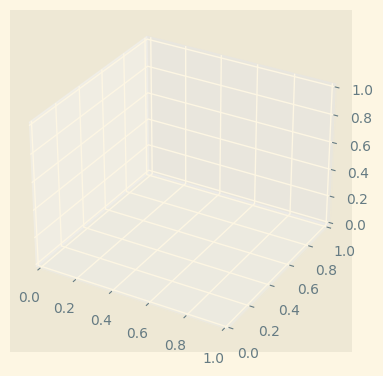

In [46]:
# Configurar la figura con tres subplots
fig = plt.figure(figsize=(15, 5))

# Definir los ángulos para cada vista
angles = [(10, 0), (90, 0), (10, 90)]

# Crear subplots con diferentes vistas usando la función
for i, angle in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_3d_scatter(ax, auxm, view_angle=angle)

# Añadir una leyenda fuera de los subplots
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Modelo 2: DBSCAN

#### Análisis Exploratorio
A partir del scatterplot del preprocesamiento, donde pueden visualizarse 5 grupos, se tratará de determinar los valores óptimos de `eps` y `min_samples` para el algoritmo DBSCAN.

##### Determinar **min_samples**

El valor de min_samples suele establecerse como **mínimo** en función de la dimensionalidad de los datos:
 
**min_samples ≥ dimensionalidad + 1**

En este caso:
min_samples ≥ 7 + 1


##### Determinar **eps**

Se utiliza la gráfica **Distancia del vecino más cercano (k-distance graph)** para determinar un valor adecuado de eps.

En este método, se calcula la distancia al k-ésimo vecino más cercano para cada punto en el dataset, donde k se establece como min_samples. Las distancias se ordenan y se grafican. El "codo" en esta gráfica indica un cambio abrupto en las distancias, lo que sugiere un valor adecuado para eps.

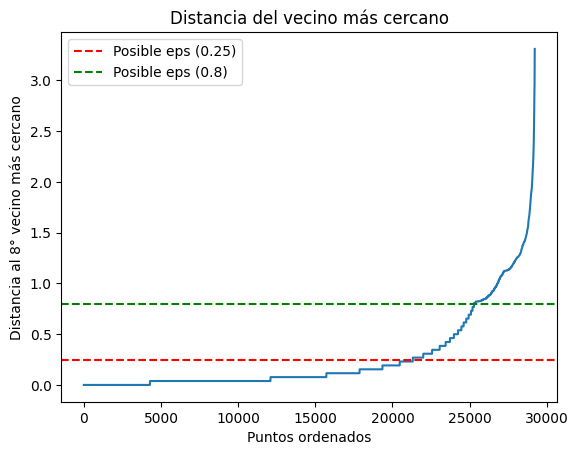

In [ ]:
# Definir min_samples
min_samples = 8

# Calcular las distancias al vecino más cercano
vecinos = NearestNeighbors(n_neighbors = min_samples)
neighbors_fit = vecinos.fit(pca_df)  # dataset reducido con PCA
distancias, indices = neighbors_fit.kneighbors(pca_df)

# Ordenar las distancias y graficar
distancias = np.sort(distancias[:, -1])
plt.plot(distancias)
plt.title('Distancia del vecino más cercano')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {min_samples}° vecino más cercano')

# Añadir líneas horizontales en puntos clave
plt.axhline(y=0.25, color='r', linestyle='--', label='Posible eps (0.25)')
plt.axhline(y=0.8, color='g', linestyle='--', label='Posible eps (0.8)')

# Añadir leyenda
plt.legend()

plt.show()

En esta gráfica pueden visualizarse 2 codos, uno en 0.25 y otro en 0.8. Se analizan ambos valores con DBSCAN para determinar el óptimo.

#### Búsqueda de mejores parámetros

Se itera sobre 5 valores de prueba para `min_samples`: 5, 10, 20, 50, 100, 200.

Se itera sobre valores de prueba para `eps`: entre 0.1 y 1.5

In [ ]:
def dbscan_parameter_search(data, eps_values, min_samples_values):
    results = []
    total_points = data.shape[0]  # Total de filas en el dataset

    for eps in eps_values:
        for min_samples in min_samples_values:
            # Aplicar DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            # Contar el número de clusters, excluyendo el ruido (-1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            # Contar la cantidad de puntos de ruido (label = -1)
            n_noise = np.sum(labels == -1)
            
            # Calcular el porcentaje de ruido
            noise_percentage = (n_noise / total_points) * 100
            
            # Almacenar los resultados
            results.append((eps, min_samples, n_clusters, n_noise, noise_percentage))
    
    # Convertir resultados en un DataFrame
    results_df = pd.DataFrame(results, columns=['eps', 'min_samples', '# clusters', '# noise points', 'Noise %'])
    return results_df

In [ ]:
# Definir valores de eps y min_samples a probar
eps_values = np.arange(0.1, 1.5, 0.25)  # Valores de eps desde 0.1 hasta 2.0, con un paso de 0.25
min_samples_values = [5, 10, 20, 50, 100, 200]  # diferentes valores de min_samples

# 'pca_df' es el dataset reducido con PCA
data = pca_df.values

# Ejecutar la búsqueda de parámetros
results_df = dbscan_parameter_search(data, eps_values, min_samples_values)

# Mostrar los resultados
print(results_df)

     eps  min_samples  # clusters  # noise points     Noise %
0   0.10            5         687            8389   28.705858
1   0.10           10         276           13774   47.132494
2   0.10           20         113           19834   67.868875
3   0.10           50          14           26662   91.233233
4   0.10          100           1           29122   99.650972
5   0.10          200           0           29224  100.000000
6   0.35            5         566            3395   11.617164
7   0.35           10         351            5799   19.843279
8   0.35           20         203            9654   33.034492
9   0.35           50          77           16566   56.686285
10  0.35          100          23           23110   79.078839
11  0.35          200           7           26661   91.229811
12  0.60            5         616            2610    8.931016
13  0.60           10         408            4277   14.635231
14  0.60           20         254            7071   24.195866
15  0.60

Para seleccionar las 3 mejores combinaciones para evaluar DBSCAN, se utilizará un proceso basado en criterios que maximicen el número de clusters útiles y minimicen la cantidad de ruido, así como aseguren una buena diferenciación entre clusters.

**1. Filtrar Configuraciones con Pocos Clusters**:

Descartar configuraciones con un número muy bajo de clusters (menos de 5 clusters), ya que podrían no capturar la estructura interna del dataset de manera efectiva.

**2. Maximizar el Número de Clusters**:

Seleccionar configuraciones con un número relativamente alto de clusters.

**3. Ruido Moderado**:

Seleccionar configuraciones con ruido, pero que no dominen el dataset.

**4. Evaluar Diversos Valores de eps y min_samples**:

Seleccionar combinaciones de eps y min_samples que no sean muy similares entre sí, para asegurar probar distintas configuraciones.

In [ ]:
# Filtrar configuraciones con al menos 5 clusters y menos del 50% de ruido
filtered_df = results_df[(results_df['# clusters'] >= 5) & (results_df['Noise %'] < 50)]

# Ordenar por el número de clusters (descendente) y luego por la cantidad de ruido (ascendente)
sorted_df = filtered_df.sort_values(by=['# clusters', '# noise points'], ascending=[False, True])

# Seleccionar los 3 mejores conjuntos de parámetros
top_3 = sorted_df.head(3)

print(top_3)

     eps  min_samples  # clusters  # noise points    Noise %
0   0.10            5         687            8389  28.705858
12  0.60            5         616            2610   8.931016
18  0.85            5         583            1382   4.728990


##### Aplicación de DBSCAN a mejores parámetros

Aplicar DBSCAN a cada combinación de `eps` y `min_samples`.

In [ ]:
# Aplicar DBSCAN a las distintas combinaciones
def run_dbscan(data, eps, min_samples):
    # Inicia el temporizador
    start_time = time.time()
    
    # Ejecuta DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    
    # Calcula el tiempo de ejecución
    elapsed_time = time.time() - start_time
    
    return labels, elapsed_time


labels1, execution_time1 = run_dbscan(pca_df, eps=0.10, min_samples=5)

labels2, execution_time2 = run_dbscan(pca_df, eps=0.6, min_samples=5)

labels3, execution_time3 = run_dbscan(pca_df, eps=0.85, min_samples=5)

#### Evaluación de modelos

Se realizarán varias comparaciones para determinar la mejor combinación de `eps` y `min_samples` obtenidas en el paso anterior.

In [ ]:
final_dbscan_df_1 = pca_df
final_dbscan_df_1['cluster_label'] = labels1

final_dbscan_df_1.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster_label
0,-0.165309,0.364004,-1.835499,1.197803,0.055517,-0.155620,-0.334023,0
1,0.508595,-2.543623,0.255155,0.212306,0.338159,0.618653,-0.051432,206
2,-1.364998,-1.036843,1.276457,-1.286142,-0.470775,0.921527,0.871006,1
3,1.015854,-1.462214,0.805133,-0.977688,-0.045681,1.071606,-0.700025,2
4,-0.904043,-0.407459,-0.082161,-0.391612,1.112086,-0.471958,-0.424371,3


In [ ]:
final_dbscan_df_2 = pca_df
final_dbscan_df_2['cluster_label'] = labels2

final_dbscan_df_2.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster_label
0,-0.165309,0.364004,-1.835499,1.197803,0.055517,-0.155620,-0.334023,0
1,0.508595,-2.543623,0.255155,0.212306,0.338159,0.618653,-0.051432,1
2,-1.364998,-1.036843,1.276457,-1.286142,-0.470775,0.921527,0.871006,2
3,1.015854,-1.462214,0.805133,-0.977688,-0.045681,1.071606,-0.700025,3
4,-0.904043,-0.407459,-0.082161,-0.391612,1.112086,-0.471958,-0.424371,4


In [ ]:
final_dbscan_df_3 = pca_df
final_dbscan_df_3['cluster_label'] = labels3

final_dbscan_df_3.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster_label
0,-0.165309,0.364004,-1.835499,1.197803,0.055517,-0.155620,-0.334023,0
1,0.508595,-2.543623,0.255155,0.212306,0.338159,0.618653,-0.051432,1
2,-1.364998,-1.036843,1.276457,-1.286142,-0.470775,0.921527,0.871006,2
3,1.015854,-1.462214,0.805133,-0.977688,-0.045681,1.071606,-0.700025,3
4,-0.904043,-0.407459,-0.082161,-0.391612,1.112086,-0.471958,-0.424371,4


##### Visualización de Clusters en las Componentes Principales

Al reducir dimensionalmente el dataset con PCA a 7 componentes, se visualizan los resultados de los clusters utilizando las 3 primeras componentes principales junto con los labels calculados con DBSCAN. Esto permitirá evaluar visualmente la diferenciación entre clusters para cada configuración.

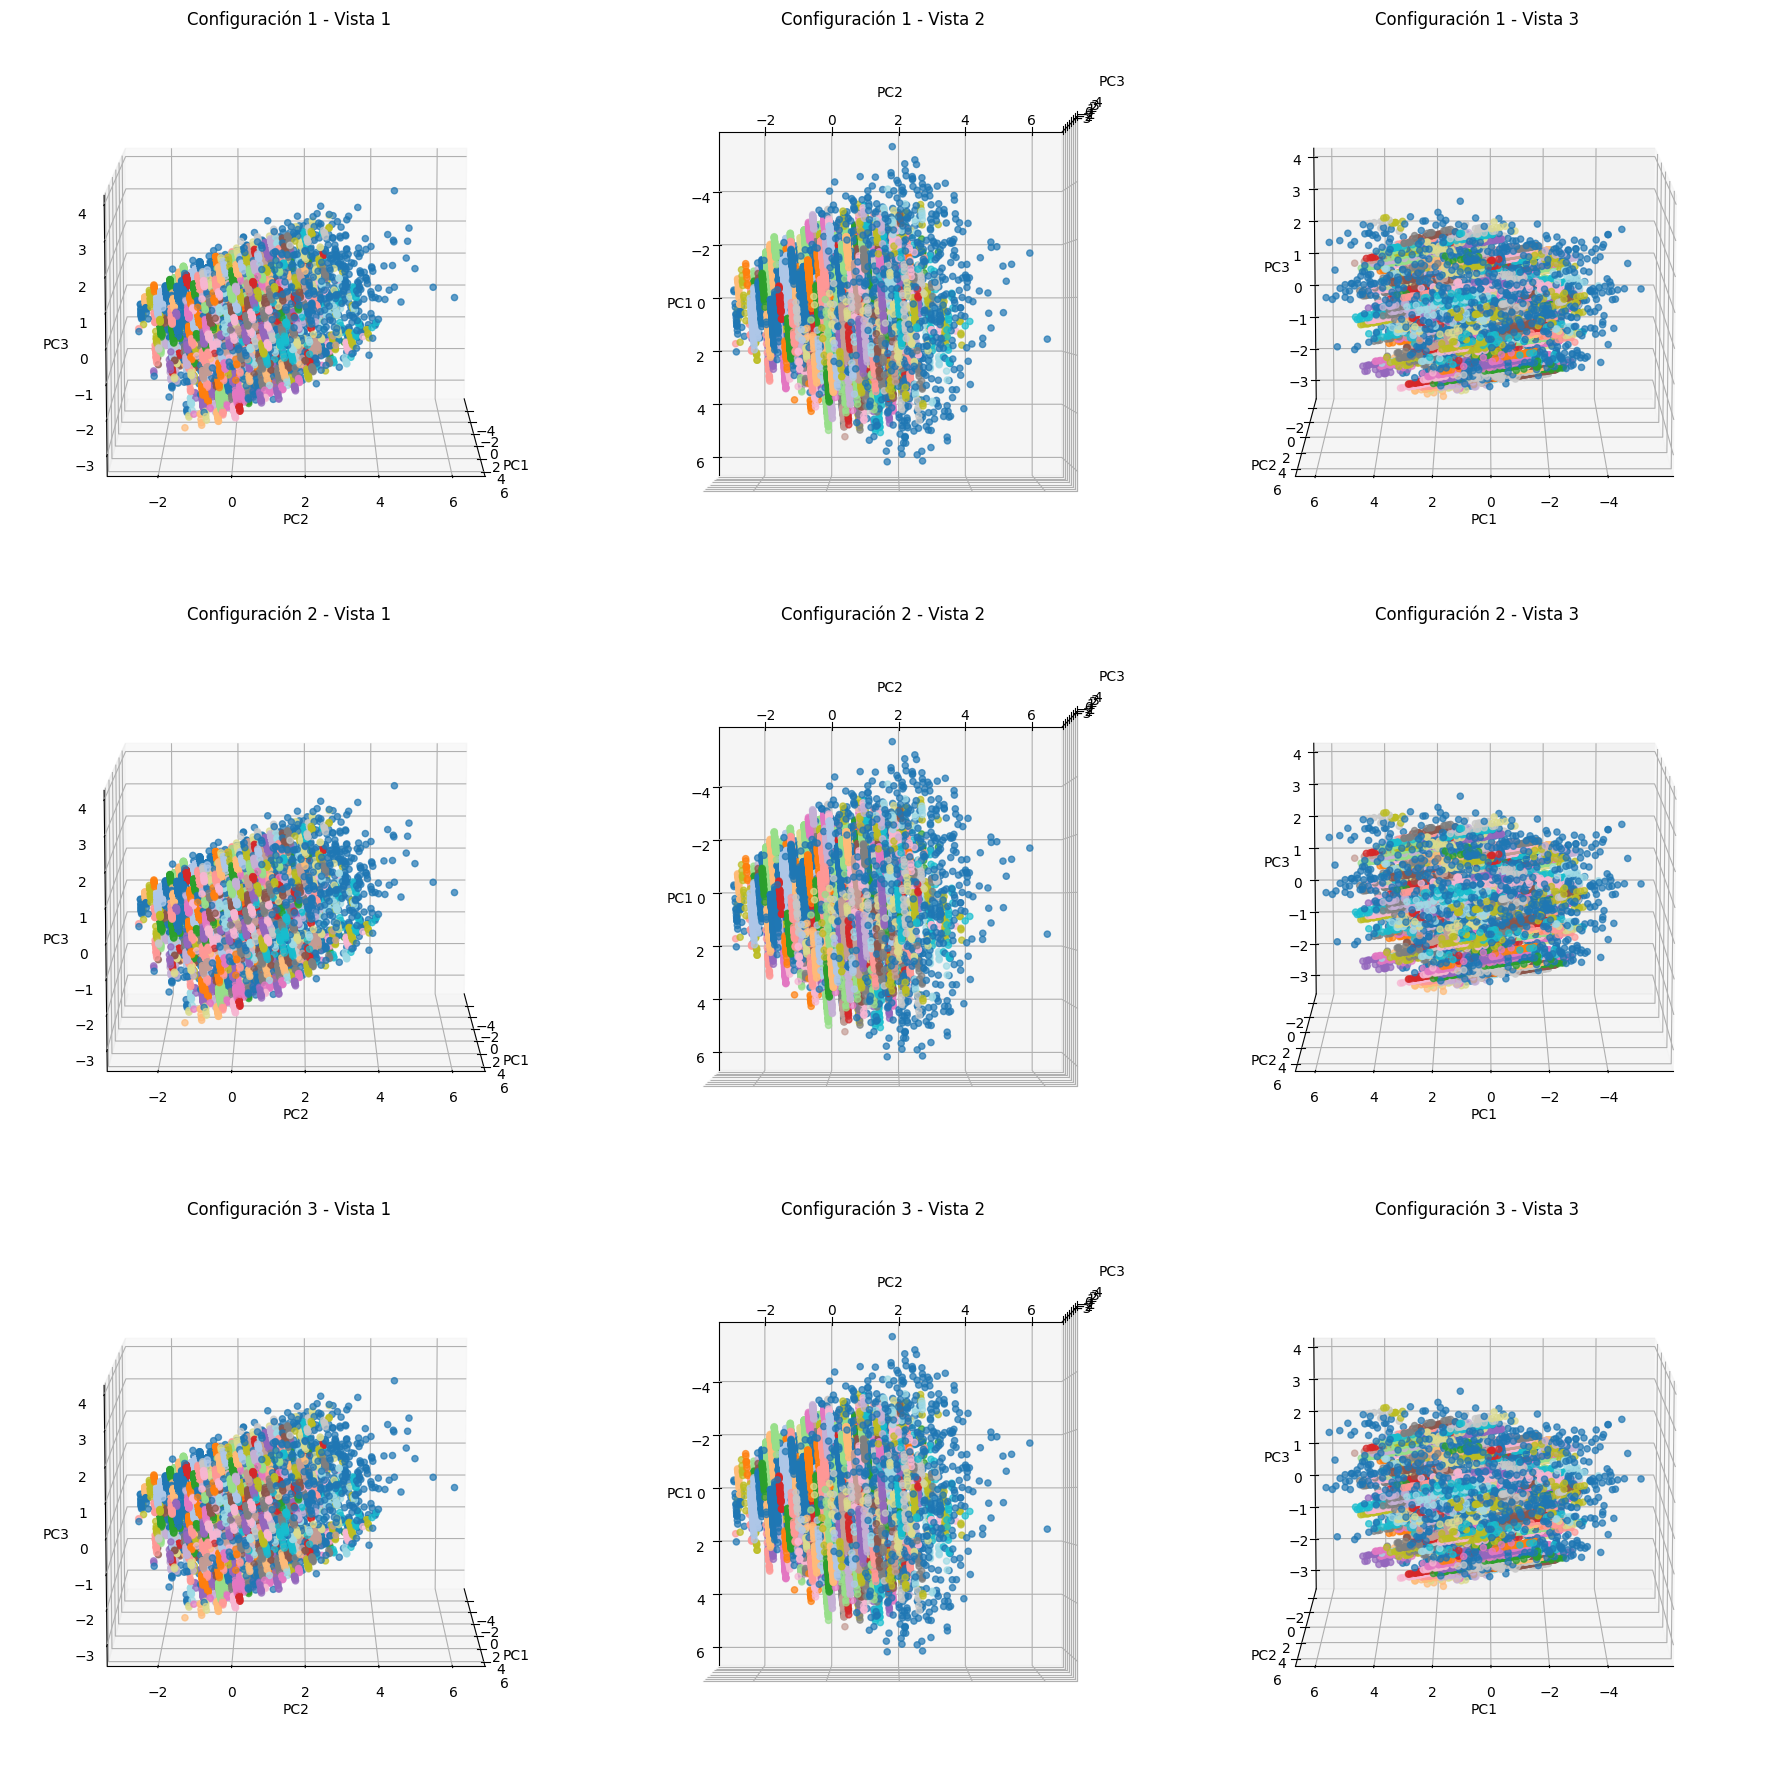

In [ ]:
# Listas de datasets
datasets = [final_dbscan_df_1, final_dbscan_df_2, final_dbscan_df_3]
titles = ["Configuración 1", "Configuración 2", "Configuración 3"]
angles = [(10, 0), (90, 0), (10, 90)]  # Ángulos de visualización

fig, axes = plt.subplots(3, 3, figsize=(18, 18), subplot_kw={'projection': '3d'})

for i, df in enumerate(datasets):
    for j, (elev, azim) in enumerate(angles):
        ax = axes[i, j]
        scatter = ax.scatter(df['PC1'], df['PC2'], df['PC3'], 
                             c=df['cluster_label'], cmap='tab20', marker='o', alpha=0.7)
        
        # Configurar los ángulos de visualización
        ax.view_init(elev=elev, azim=azim)
        
        # Etiquetas de los ejes
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        
        # Títulos personalizados
        ax.set_title(f"{titles[i]} - Vista {j+1}")
        
# Ajustar layout
plt.tight_layout()
plt.show()

Las 3 configuraciones muestran una gran cantidad de clusters, sin una clara diferenciación entre ellas. Puede visualizarse una menor cantidad de ruido en la `Configuracion 3`, por lo que optaremos por elegirla como la mejor opción.

##### Evaluación Estadística de los Clusters

Calcular **Silhouette score** para cada configuración de DBSCAN para determinar cohesión y separación de los clusters.

In [ ]:
def evaluate_silhouette(data, labels):
    if len(set(labels)) > 1:  # Al menos dos clusters para calcular silhouette
        score = silhouette_score(data, labels)
        return score
    return None

# Evaluar cada configuración
silhouette_1 = evaluate_silhouette(pca_df, labels1)
silhouette_2 = evaluate_silhouette(pca_df, labels2)
silhouette_3 = evaluate_silhouette(pca_df, labels3)

print(f"Silhouette Score Configuración 1: {silhouette_1:.2f}")
print(f"Silhouette Score Configuración 2: {silhouette_2:.2f}")
print(f"Silhouette Score Configuración 3: {silhouette_3:.2f}")

Silhouette Score Configuración 1: 0.18
Silhouette Score Configuración 2: 0.61
Silhouette Score Configuración 3: 0.73


* Un valor cercano a 1 indica que los puntos están bien agrupados en sus clusters.

* Un valor cercano a 0 indica que los puntos están en el límite entre dos clusters.

* Un valor negativo indica que los puntos pueden estar mal agrupados.

En base al Silhouette Score, podemos determinar que la `Configuración 3` es la que agrupa mejor los puntos en el cluster.

##### Análisis de Distribución de Clusters y Ruido

Analizar la distribución de los clusters, observando la cantidad de puntos en cada cluster y la cantidad de puntos de ruido.

Clusters muy pequeños podrían ser indicativos de parámetros no ideales, mientras que una cantidad muy alta de ruido puede significar que los parámetros son demasiado estrictos.

In [ ]:
def analyze_cluster_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    cluster_info = dict(zip(unique, counts))    

    # Calcular número de ruidos (puntos con label -1)
    num_ruido = cluster_info.get(-1, 0)
    
    # Calcular porcentaje de errores
    total_points = np.sum(counts)
    error_percentage = (num_ruido / total_points) * 100
    
    # Excluir los errores para calcular el mínimo y máximo tamaño de cluster
    valid_clusters = [count for label, count in cluster_info.items() if label != -1]
    if valid_clusters:
        min_cluster_size = np.min(valid_clusters)
        max_cluster_size = np.max(valid_clusters)
    else:
        min_cluster_size = max_cluster_size = 0
    
    analysis = {
        "# Ruido": num_ruido,
        "% Ruido": error_percentage,
        "# Mín Ptos/Cluster": min_cluster_size,
        "# Máx Ptos/Cluster": max_cluster_size
    }
    
    return analysis

# Analizar la distribución de los clusters para cada configuración
distribution_1 = analyze_cluster_distribution(labels1)
distribution_2 = analyze_cluster_distribution(labels2)
distribution_3 = analyze_cluster_distribution(labels3)

# Crear un DataFrame para comparar las configuraciones
comparative_df = pd.DataFrame({
    "Configuración 1": distribution_1,
    "Configuración 2": distribution_2,
    "Configuración 3": distribution_3
})

# Transponer el DataFrame para una mejor visualización
comparative_df = comparative_df.T

print(comparative_df)

                 # Ruido    % Ruido  # Mín Ptos/Cluster  # Máx Ptos/Cluster
Configuración 1   8389.0  28.705858                 3.0               650.0
Configuración 2   2610.0   8.931016                 4.0               651.0
Configuración 3   1389.0   4.752943                 5.0               651.0


Las 3 configuraciones muestran una gran amplitud de tamaño de los clusters, teniendo algunos con pocos puntos y otros con 650 aproximadamente. El único punto que ayuda a inclinarse por la `Configuración 3` es el ruido, que sólo representa casi el 5% del dataset.

##### Tiempo de Ejecución

Medir y comparar el tiempo de ejecución para cada configuración.

In [ ]:
print(f"Tiempo de ejecución Configuración 1: {execution_time1:.2f} segundos")

print(f"Tiempo de ejecución Configuración 2: {execution_time2:.2f} segundos")

print(f"Tiempo de ejecución Configuración 3: {execution_time3:.2f} segundos")

Tiempo de ejecución Configuración 1: 0.42 segundos
Tiempo de ejecución Configuración 2: 0.49 segundos
Tiempo de ejecución Configuración 3: 0.50 segundos


Las 3 configuraciones se ejecutan por debajo del minuto, siendo la `Configuración 1` la que se ejecuta en menor tiempo.

##### Conclusión

Después de analizar visualmente los clusters, evaluar métricas estadísticas, analizar la distribución de los clusters y medir el tiempo de ejecución, se selecciona la configuración que ofrece un buen equilibrio entre cohesión, separación, ruido y eficiencia:

**Configuración 3**:

* eps: 0.85

* min_samples: 5         

* num clusters: 583

* num ruido: 1382

* % ruido: 4.73

* Silhouette Score: 0.73

* Tiempo de ejecución: 0.50 segundos

Tras un análisis exhaustivo utilizando la **configuración óptima** para el algoritmo DBSCAN, se ha determinado que este enfoque **no es adecuado** para el dataset en cuestión debido a su alta densidad. 

El algoritmo identificó casi 600 clusters, lo que dificulta significativamente la interpretación y la identificación de las características clave que influyen en este clustering dentro del dataset original. Esto sugiere que DBSCAN, aunque efectivo en otros contextos, no es la mejor opción para este tipo de datos, y sería recomendable explorar otros métodos de clustering o enfoques alternativos para obtener resultados más interpretables y útiles.